In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [20]:
def prepare_image(file):
    img_path = r'C:\Users\parth\Desktop\photos'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

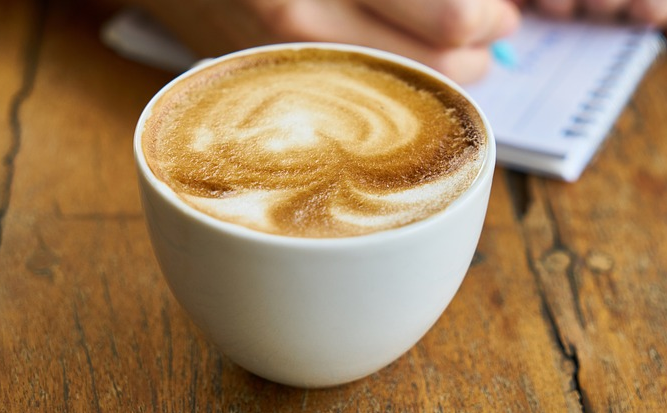

In [40]:
from IPython.display import Image
Image(filename=r'C:\Users\parth\Desktop\photos\e.PNG', width=300,height=200) 

In [41]:
preprocessed_image = prepare_image('\e.png')
predictions = mobile.predict(preprocessed_image)

In [42]:
results = imagenet_utils.decode_predictions(predictions)

In [43]:
results

[[('n07920052', 'espresso', 0.9867621),
  ('n07930864', 'cup', 0.006894743),
  ('n07932039', 'eggnog', 0.0028749623),
  ('n03063599', 'coffee_mug', 0.0021079541),
  ('n04597913', 'wooden_spoon', 0.0010108596)]]

FINE TUNE MOBILENET

In [44]:
train_path=r'C:\Users\parth\Documents\data\d-vs-c\train'
test_path=r'C:\Users\parth\Documents\data\d-vs-c\test'
valid_path=r'C:\Users\parth\Documents\data\d-vs-c\valid'

In [45]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


MODIFY MODEL

In [46]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [48]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [50]:
x = mobile.layers[-6].output
predictions=Dense(2,activation='softmax')(x)
model=Model(inputs=mobile.input,outputs=predictions)

In [52]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [53]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [54]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10
100/100 - 41s - loss: 0.2004 - accuracy: 0.9110 - val_loss: 0.2280 - val_accuracy: 0.8900
Epoch 2/10
100/100 - 38s - loss: 0.0543 - accuracy: 0.9820 - val_loss: 0.0392 - val_accuracy: 0.9850
Epoch 3/10
100/100 - 38s - loss: 0.0472 - accuracy: 0.9830 - val_loss: 0.0285 - val_accuracy: 0.9950
Epoch 4/10
100/100 - 38s - loss: 0.0383 - accuracy: 0.9840 - val_loss: 0.0264 - val_accuracy: 0.9850
Epoch 5/10
100/100 - 38s - loss: 0.0242 - accuracy: 0.9930 - val_loss: 0.0279 - val_accuracy: 0.9900
Epoch 6/10
100/100 - 38s - loss: 0.0227 - accuracy: 0.9940 - val_loss: 0.0620 - val_accuracy: 0.9700
Epoch 7/10
100/100 - 38s - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.0223 - val_accuracy: 0.9900
Epoch 8/10
100/100 - 39s - loss: 0.0181 - accuracy: 0.9940 - val_loss: 0.0203 - val_accuracy: 0.9950
Epoch 9/10
100/100 - 38s - loss: 0.0152 - accuracy: 0.9950 - val_loss: 0.0419 - val_accuracy: 0.9700
Epoch 10/10
100/100 - 38s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0220 - val_accura

In [56]:
test_labels=test_batches.classes

In [57]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
test_batches .class_indices

{'cat': 0, 'dog': 1}

In [59]:
predictions = model.predict(x=test_batches, verbose=0)

In [64]:
def plot_confusion_matrix(cm, classes,
        normalize=True,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [66]:
cm_plot_labels = ['cat','dog']

Normalized confusion matrix
[[0.98 0.02]
 [0.06 0.94]]


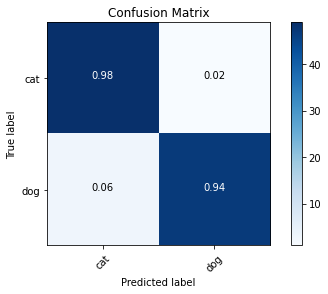

In [67]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [82]:
%cd C:\Users\parth\Untitled Folder\Dataset
%mkdir test
%mkdir valid
%mkdir train

C:\Users\parth\Untitled Folder\Dataset


In [88]:
## %mv 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/ train/

In [91]:
%cd C:\Users\parth\Untitled Folder\Dataset\valid
%mkdir 0

C:\Users\parth\Untitled Folder\Dataset\valid


In [92]:
%cd C:\Users\parth\Untitled Folder\Dataset\valid
%mkdir 1
%mkdir 2
%mkdir 3
%mkdir 4
%mkdir 5
%mkdir 6
%mkdir 7
%mkdir 8
%mkdir 9

C:\Users\parth\Untitled Folder\Dataset\valid


In [93]:
%cd C:\Users\parth\Untitled Folder\Dataset\test
%mkdir 0
%mkdir 1
%mkdir 2
%mkdir 3
%mkdir 4
%mkdir 5
%mkdir 6
%mkdir 7
%mkdir 8
%mkdir 9

C:\Users\parth\Untitled Folder\Dataset\test


In [100]:
##%%bash
##cd ../train
##for((i=0;i<=9;i++)); do
##    a=$(find $i/ -type f| shuf -n 30)
##    mv $a ..valid/$i
    

In [99]:
# Organize data into train, valid, test dirs
os.chdir(r'C:\Users\parth\Untitled Folder\Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [102]:
train_path = r'C:\Users\parth\Untitled Folder\Dataset\train'
valid_path = r'C:\Users\parth\Untitled Folder\Dataset\valid'
test_path = r'C:\Users\parth\Untitled Folder\Dataset\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [103]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [104]:
x = mobile.layers[-6].output
predictions=Dense(10,activation='softmax')(x)

In [105]:
model=Model(inputs=mobile.input, outputs=predictions)

In [106]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [107]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [108]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30,
          verbose=2
)

Epoch 1/30
172/172 - 99s - loss: 0.5509 - accuracy: 0.8435 - val_loss: 0.7274 - val_accuracy: 0.7000
Epoch 2/30
172/172 - 98s - loss: 0.0931 - accuracy: 0.9860 - val_loss: 0.3526 - val_accuracy: 0.8967
Epoch 3/30
172/172 - 100s - loss: 0.0535 - accuracy: 0.9942 - val_loss: 0.3517 - val_accuracy: 0.8833
Epoch 4/30
172/172 - 102s - loss: 0.0326 - accuracy: 0.9971 - val_loss: 0.2746 - val_accuracy: 0.9367
Epoch 5/30
172/172 - 100s - loss: 0.0176 - accuracy: 0.9988 - val_loss: 0.2811 - val_accuracy: 0.9233
Epoch 6/30
172/172 - 94s - loss: 0.0125 - accuracy: 0.9994 - val_loss: 0.2510 - val_accuracy: 0.9367
Epoch 7/30
172/172 - 95s - loss: 0.0114 - accuracy: 0.9994 - val_loss: 0.2032 - val_accuracy: 0.9333
Epoch 8/30
172/172 - 95s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2445 - val_accuracy: 0.9300
Epoch 9/30
172/172 - 95s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.2245 - val_accuracy: 0.9300
Epoch 10/30
172/172 - 94s - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.2204 - val_acc

In [123]:
test_labels = test_batches.classes

In [2]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

NameError: name 'model' is not defined

In [3]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

NameError: name 'confusion_matrix' is not defined

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

NameError: name 'plt' is not defined

In [5]:
test_batches.class_indices

NameError: name 'test_batches' is not defined

In [6]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

NameError: name 'plot_confusion_matrix' is not defined

In [130]:
model.save('Mobilenet.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Mobilenet.model\assets


In [1]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

NameError: name 'plot_confusion_matrix' is not defined